In [0]:
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

## Dataset
We only use the first 22 eeg features, and transfer labels from 769-772 to 0-4.

In [0]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
X_train_valid = X_train_valid[:, :22, :]
X_test = X_test[:, :22, :]
y_train_valid = to_categorical(y_train_valid - 769)
y_test = to_categorical(y_test - 769)

## Shape of Data

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115, 4)
Test target shape: (443, 4)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## Model

CNN model for dataset over time period [100, 450)

In [0]:
def cnn_model_smaller_than_450(time_period=450):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(1, 5), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(22, time_period, 1), data_format='channels_last'))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, kernel_size=(1, 5), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(1, 5), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, epsilon=1e-8, decay=0.01), metrics=[categorical_accuracy])
    
    return model

CNN model for dataset over time period >= 450

In [0]:
def cnn_model(time_period=1000):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(22, time_period, 1), data_format='channels_last'))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(21, 1), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, epsilon=1e-8, decay=0.01), metrics=[categorical_accuracy])
    
    return model

## Training Data

In [0]:
def train_data(time_period=1000):
    # different period of time
    X_train_valid_cur = X_train_valid[:, :, :time_period]
    y_train_valid_cur = y_train_valid
    X_test_cur = X_test[:, :, :time_period]
    y_test_cur = y_test

    # preprocess data
    X_train_valid_cur = np.expand_dims(X_train_valid_cur, axis=3)
    X_test_cur = np.expand_dims(X_test_cur, axis=3)
    lecun = lecun_uniform(seed=42)
    
    if time_period < 450:
        model = cnn_model_smaller_than_450(time_period)
    else:
        model = cnn_model(time_period)
    model.fit(X_train_valid_cur, y_train_valid_cur, epochs=40, batch_size=32, validation_data=(X_test_cur, y_test_cur), shuffle=True, verbose=1)
    train_score = model.evaluate(X_train_valid_cur, y_train_valid_cur)
    test_score = model.evaluate(X_test_cur, y_test_cur)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    print(model.summary())
    
    return train_score, test_score


##All Subjects over Time = 1000

In [7]:
train_score, test_score = train_data(1000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2115 samples, validate on 443 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
2115/2115 [==============================] - 6s 3ms/sample - loss: 3.4535 - categorical_accuracy: 0.2742 - val_loss: 3.1801 - val_categorical_accuracy: 0.3025
Epoch 2/40
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.8705 - categorical_accuracy: 0.2582 - val_loss: 2.6344 - val_categorical_accuracy: 0.2822
Epoch 3/40
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.6415 - categorical_accuracy: 0.3102 - val_loss: 2.4451 - val_categorical_accuracy: 0.3025
Epoch 4/40
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.4685 - categorical_accuracy: 0.3395 - val_loss: 2.3093 - val_categorical_accuracy: 0.3589
Epoch 5/40
2115/2115 [================

##Function of Time

=================100===================
Train on 2115 samples, validate on 443 samples
Epoch 1/40
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.9847 - categorical_accuracy: 0.3149 - val_loss: 2.4800 - val_categorical_accuracy: 0.3589
Epoch 2/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 2.2381 - categorical_accuracy: 0.3882 - val_loss: 2.2635 - val_categorical_accuracy: 0.3837
Epoch 3/40
2115/2115 [==============================] - 2s 1ms/sample - loss: 2.1269 - categorical_accuracy: 0.4080 - val_loss: 2.1461 - val_categorical_accuracy: 0.3860
Epoch 4/40
2115/2115 [==============================] - 2s 854us/sample - loss: 2.0193 - categorical_accuracy: 0.4374 - val_loss: 1.9808 - val_categorical_accuracy: 0.3973
Epoch 5/40
2115/2115 [==============================] - 1s 571us/sample - loss: 1.9940 - categorical_accuracy: 0.4572 - val_loss: 1.8951 - val_categorical_accuracy: 0.4289
Epoch 6/40
2115/2115 [==============================] - 1s 

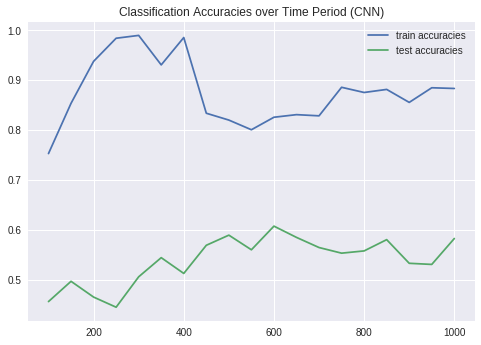

In [8]:
train_scores = []
test_scores = []

for time in range(100, 1001, 50):
    print("=================" + str(time) + "===================")
    train_score, test_score = train_data(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)
max_idx = np.argmax(test_scores)
print("The best accuracy is %.3f." %max(test_scores))
print("The corresponding time period is %d." %(100 + 50 * max_idx))

# plot
plt.plot(range(100, 1001, 50), train_scores, label='train accuracies')
plt.plot(range(100, 1001, 50), test_scores, label='test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN)")
plt.show()